In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
from __future__ import print_function
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob

from scipy.stats import mode
from sklearn.metrics import f1_score

In [79]:
!ls ../tfhub/inference

inception_v3  mobilenet_v1_025_128  mobilenet_v2_100_128  nasnet_mobile


In [6]:
def draw_contour(mask, rgb):
    if rgb.shape[0] != mask.shape[0]:
        x_, y_ = mask.shape[:2]
        rgb = cv2.resize(rgb, dsize=(y_, x_))
    mask = (mask != 6).astype(np.uint8)
    print(mask.shape, rgb.shape)
    im2, contours, hierarchy = cv2.findContours(mask,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)    
#     print(contours)
    rgb2 = np.copy(rgb)
    cv2.drawContours(rgb2, contours, 0, (0,0,0), 5)
    return rgb2

def draw_contour_all(mask, rgb):
    mask = (mask != 6).astype(np.uint8)
    print(mask.shape, rgb.shape)
    im2, contours, hierarchy = cv2.findContours(mask,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)    
#     print(contours)
    rgb2 = np.copy(rgb)
    cv2.drawContours(rgb2, contours, -1, (0,0,0), 3)
    return rgb2

mask_list = glob.glob('../data/validation_svs/*png')
mask_paths = pd.DataFrame(mask_list, index=[os.path.basename(x).replace('.png', '') for x in mask_list])

# Evaluate performance

In [4]:
BACKGROUND = 255
def get_regions(mask, thresh=500):
#     label_images = {x: np.zeros_like(mask) for x in range(5)}
    label_images = []
    label_codes = []
    
    labels = np.unique(mask)
    image = (mask < BACKGROUND).astype(np.uint8)
    
    _, contours, hierarchy = cv2.findContours(image, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
        
    for cnt_num, _ in enumerate(contours):
        dummy_image = np.zeros_like(mask)
        cv2.drawContours(dummy_image, contours, cnt_num, 1, -1)
        ## Check area -- 
        pos_area = dummy_image.sum()
        if pos_area < thresh:
            continue
        dummy_image = dummy_image.astype(np.bool)
        cnt_label = mode(mask[dummy_image])[0][0]
        label_images.append(np.copy(dummy_image))
        label_codes.append(cnt_label)
        
    return label_images, label_codes

<Figure size 432x288 with 0 Axes>

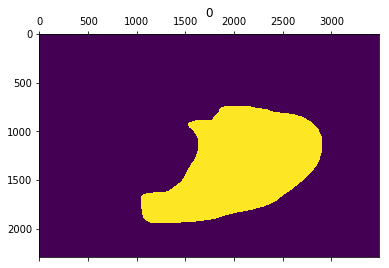

<Figure size 432x288 with 0 Axes>

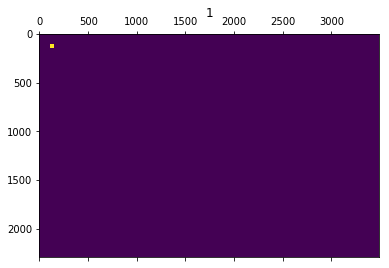

<Figure size 432x288 with 0 Axes>

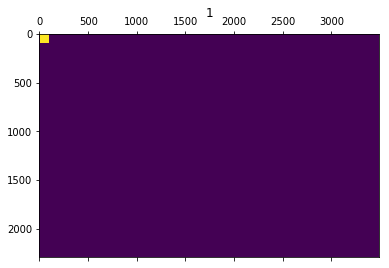

In [69]:
## Test for the get_regions function
np.unique(mask)
mask2 = np.copy(mask)
mask2[10:100, 10:100] = 1
mask2[110:150, 110:150] = 1
label_images, label_codes = get_regions(mask2)

for LI, LC in zip(label_images, label_codes): 
    plt.figure()
    plt.matshow(LI)
    plt.title(LC)

In [18]:
def perform_comparison(glob_path):
    inf_list = glob.glob(glob_path) # Where to glob for outputs
    print(len(inf_list))
    grade_dict = {0: 'G3', 1: 'G4', 2: 'G5', 3: 'BN', 4: 'ST'}
    attrib = ['Region', 'Slide', 'Region_area', 'TotalAcc', 'EpitheliumAcc', 
              'EpitheliumF1', 'Class_Label', 'Stroma_Area']
    attrib += ['{}'.format(x) for y,x in grade_dict.items()]
    performance = {k: [] for k in attrib}

    ## Reduce to slides we have annotated
    inf_bases = [os.path.basename(infp).replace('_prob.npy', '') for infp in inf_list]
    inf_list = [infp for infp, infb in zip(inf_list, inf_bases) if infb in mask_paths.index]
    print(len(inf_list))

    for idx, inf_path in enumerate(inf_list):
        inf_base = os.path.basename(inf_path).replace('_prob.npy', '')

        if inf_base not in mask_paths.index:
            print('{} no mask'.format(inf_base))
            continue

        mask = cv2.imread(mask_paths.loc[inf_base,0], -1)
        x = np.load(inf_path)
        x_, y_ = x.shape[:2]
        mask = cv2.resize(mask, dsize=(y_, x_), interpolation=cv2.INTER_NEAREST)
        label_images, label_codes = get_regions(mask)

        amax = np.argmax(x, axis=-1)
        amax[mask==255] = 255

        ## Loop over the present classes:
        region = 0
        for LI, LC in zip(label_images, label_codes):
            ## pull out annotated area
            amax_region = amax[LI]
            total_size = float(amax_region.shape[0])

            ## pull out non-stroma
            stroma_area = (amax_region == 4).sum()
            amax_region = amax_region[amax_region != 4]
            non_stroma_size = float(amax_region.shape[0])

            ## Reassign 2 --> 1 ( G5 / 4+5 --> G4 )
            amax_region[amax_region == 2] = 1

        #     ## Remove BN
        #     amax_region = amax_region[amax_region != 3]
            if LC == 2: LC = 1
            gt_region = np.zeros_like(amax_region) + LC
            total_acc = (amax_region == LC).sum() / total_size
            epithelium_acc = (amax_region == LC).sum() / non_stroma_size
            epithelium_f1 = f1_score(gt_region, amax_region, average='weighted')

            performance['Region'].append('{}_{:02d}'.format(inf_base, region))
            performance['Slide'].append(inf_base)
            performance['Region_area'].append(total_size)
            performance['TotalAcc'].append(total_acc)
            performance['EpitheliumAcc'].append(epithelium_acc)
            performance['EpitheliumF1'].append(epithelium_f1)
            performance['Class_Label'].append(grade_dict[LC])
            performance['Stroma_Area'].append(stroma_area)
            for co, gr in grade_dict.items():
                performance['{}'.format(gr)].append((amax_region == co).sum())
            print(idx, region, grade_dict[LC], inf_path, 'ACC:', epithelium_acc, 'F1:', epithelium_f1)
            region += 1


    perf_df = pd.DataFrame(performance, index=performance['Region'], columns=attrib[1:])
    outpath = os.path.join(os.path.split(inf_path)[0], 'processed_perf.csv')
    print(outpath)
    perf_df.to_csv(outpath, sep='\t')

In [34]:
!ls ../tfhub/inference/*

TCGA-2A-A8VL-01Z-00-DX1.2C2BD6EF-EC17-4117-AE89-A22B67AFB233_color.jpg
TCGA-2A-A8VL-01Z-00-DX1.2C2BD6EF-EC17-4117-AE89-A22B67AFB233_prob.npy
TCGA-2A-A8VO-01Z-00-DX1.3A69CC37-B066-4529-B1BE-AD155983AAA7_color.jpg
TCGA-2A-A8VO-01Z-00-DX1.3A69CC37-B066-4529-B1BE-AD155983AAA7_prob.npy
TCGA-2A-A8VT-01Z-00-DX1.F2CD9AAB-7B40-46A4-832B-1279A8A77737_color.jpg
TCGA-2A-A8VT-01Z-00-DX1.F2CD9AAB-7B40-46A4-832B-1279A8A77737_prob.npy
TCGA-2A-A8VV-01Z-00-DX1.DD094519-863E-42EF-8B36-F52418265E3E_color.jpg
TCGA-2A-A8VV-01Z-00-DX1.DD094519-863E-42EF-8B36-F52418265E3E_prob.npy
TCGA-2A-A8VX-01Z-00-DX1.2A244F16-C24E-4CE9-8820-9E36B5441EC7_color.jpg
TCGA-2A-A8VX-01Z-00-DX1.2A244F16-C24E-4CE9-8820-9E36B5441EC7_prob.npy
TCGA-2A-A8W1-01Z-00-DX1.0CA35481-A243-4722-B3E5-4FB25EC9F6C0_color.jpg
TCGA-2A-A8W1-01Z-00-DX1.0CA35481-A243-4722-B3E5-4FB25EC9F6C0_prob.npy
TCGA-2A-AAYO-01Z-00-DX1.A5BB3437-956A-4A42-AC28-1217B8016970_color.jpg
TCGA-2A-AAYO-01Z-00-DX1.A5BB3437-956A-4A42-AC28-1217B8016970_prob.npy
TCGA-2A-AAYU-

In [26]:
modelname = 'unet_small'
trainings = ['5x', '10x', '20x', '5x_FOV', '10x_FOV', '20x_FOV']
# trainings = ['10x_FOV', '20x_FOV']
glob_paths = ['../{}/{}/inference/*.npy'.format(modelname, tx) for tx in trainings]
for glob_path in glob_paths:
    print(glob_path)
    perform_comparison(glob_path)

../unet_small/5x/inference/*.npy
104
70
0 0 G3 ../unet_small/5x/inference/1304727_prob.npy ACC: 0.7747890582866024 F1: 0.8731055160263279
1 0 G4 ../unet_small/5x/inference/1305455_prob.npy ACC: 0.22168009808586542 F1: 0.3629102224603559
2 0 G3 ../unet_small/5x/inference/1304700_prob.npy ACC: 0.9347953625865352 F1: 0.9662989488840329
3 0 G4 ../unet_small/5x/inference/1305496_prob.npy ACC: 0.4500892729420865 F1: 0.6207745706978444
4 0 G3 ../unet_small/5x/inference/1304718_prob.npy ACC: 0.7651814994911229 F1: 0.8669720362599699
5 0 G4 ../unet_small/5x/inference/1305495_prob.npy ACC: 0.626689127817837 F1: 0.7705087801976336
6 0 G3 ../unet_small/5x/inference/1304728_prob.npy ACC: 0.7647835656639765 F1: 0.8667165544192235
6 1 G3 ../unet_small/5x/inference/1304728_prob.npy ACC: 0.9025809910392892 F1: 0.9487963932050558
6 2 G3 ../unet_small/5x/inference/1304728_prob.npy ACC: 0.9463955057590309 F1: 0.9724596085007577
6 3 G3 ../unet_small/5x/inference/1304728_prob.npy ACC: 0.8318780318780319 F1:

64 0 G4 ../unet_small/5x/inference/1305488_prob.npy ACC: 0.42969293628561744 F1: 0.6010982153999751
65 0 G4 ../unet_small/5x/inference/1305449_prob.npy ACC: 0.5568844473099792 F1: 0.715383146478439
66 0 G4 ../unet_small/5x/inference/1305451_prob.npy ACC: 0.43883141356029504 F1: 0.6099830868641312
67 0 G4 ../unet_small/5x/inference/1305461_prob.npy ACC: 0.6810104347044997 F1: 0.8102393901251572
68 0 G3 ../unet_small/5x/inference/1304713_prob.npy ACC: 0.8429035136007289 F1: 0.9147559895350514
69 0 G4 ../unet_small/5x/inference/1305487_prob.npy ACC: 0.5328693147725909 F1: 0.6952573316423192
69 1 G4 ../unet_small/5x/inference/1305487_prob.npy ACC: 0.2871154284794247 F1: 0.44613780881893045
../unet_small/5x/inference/processed_perf.csv
../unet_small/10x/inference/*.npy
34
0


UnboundLocalError: local variable 'inf_path' referenced before assignment

In [34]:
perf_df = pd.DataFrame(performance, index=performance['Region'], columns=attrib[1:])
print(np.mean(perf_df.EpitheliumF1))
print(np.std(perf_df.EpitheliumF1))
perf_df

0.7336470977624209
0.23923788577288946


,Slide,Region_area,TotalAcc,EpitheliumAcc,EpitheliumF1,Class_Label,Stroma_Area,G3,G4,G5,BN,ST
1305449_00,1305449,2734606.0,0.284266,0.556884,0.715383,G4,1338706,465372,777355,0,153173,0
1304700_00,1304700,449236.0,0.549760,0.934795,0.966299,G3,185037,246972,3923,0,13303,0
1304706_00,1304706,25685.0,0.424917,0.873959,0.932741,G3,13197,10914,252,0,1322,0
1304706_01,1304706,132537.0,0.567298,0.942418,0.970356,G3,52755,75188,2074,0,2520,0
1305445_00,1305445,219890.0,0.362841,0.767784,0.868640,G4,115974,20407,79785,0,3724,0
1305488_00,1305488,295444.0,0.326058,0.429693,0.601098,G4,71256,121554,96332,0,6302,0
1304704_00,1304704,530954.0,0.470086,0.825432,0.904369,G3,228574,249594,51197,0,1589,0
1305451_00,1305451,389312.0,0.180647,0.438831,0.609983,G4,229050,87453,70328,0,2481,0
1304719_00,1304719,57825.0,0.245966,0.723596,0.839635,G3,38169,14223,2473,0,2960,0
1305489_00,1305489,381674.0,0.313603,0.495135,0.662328,G4,139934,37788,119694,0,84258,0


In [31]:
perf_tables = glob.glob('../*/*/inference/processed_perf.csv')
print(perf_tables)

for perf_tab in sorted(perf_tables):
    df = pd.read_csv(perf_tab, sep='\t', header=0, index_col=0)
    basename = os.path.split(perf_tab)[0]
    print(basename, df.shape, np.mean(df['EpitheliumF1']))

['../unet/20x_FOV/inference/processed_perf.csv', '../unet/20x/inference/processed_perf.csv', '../unet/5x_FOV/inference/processed_perf.csv', '../unet/10x/inference/processed_perf.csv', '../unet/10x_FOV/inference/processed_perf.csv', '../unet/5x/inference/processed_perf.csv', '../fcn8s/20x_FOV/inference/processed_perf.csv', '../fcn8s/20x/inference/processed_perf.csv', '../fcn8s/5x_FOV/inference/processed_perf.csv', '../fcn8s/10x/inference/processed_perf.csv', '../fcn8s/10x_FOV/inference/processed_perf.csv', '../fcn8s/5x/inference/processed_perf.csv', '../unet_small/5x/inference/processed_perf.csv', '../densenet/20x_FOV/inference/processed_perf.csv', '../densenet/20x/inference/processed_perf.csv', '../densenet/5x_FOV/inference/processed_perf.csv', '../densenet/10x/inference/processed_perf.csv', '../densenet/10x_FOV/inference/processed_perf.csv', '../densenet/5x/inference/processed_perf.csv', '../densenet_small/20x_FOV/inference/processed_perf.csv', '../densenet_small/20x/inference/process

In [29]:
df

,Slide,Region_area,TotalAcc,EpitheliumAcc,EpitheliumF1,Class_Label,Stroma_Area,G3,G4,G5,BN,ST
1304727_00,1304727,1222425.0,0.143167,0.337213,0.504352,G3,703433,175011,209407,0,134574,0
1305455_00,1305455,761694.0,0.277718,0.786601,0.880556,G4,492770,30128,211536,0,27260,0
1304700_00,1304700,449236.0,0.119169,0.665502,0.799161,G3,368793,53535,19590,0,7317,0
1305496_00,1305496,366869.0,0.418452,0.891106,0.942418,G4,194592,8946,153517,0,9814,0
1304718_00,1304718,41426.0,0.088399,0.227171,0.370236,G3,25306,3662,10647,0,1811,0
1305495_00,1305495,1785940.0,0.500418,0.942219,0.970250,G4,837417,19643,893716,0,35164,0
1304728_00,1304728,28796.0,0.074837,0.201515,0.335435,G3,18102,2155,6488,0,2051,0
1304728_01,1304728,16164.0,0.479770,0.758435,0.862625,G3,5939,7755,1890,0,580,0
1304728_02,1304728,52932.0,0.149248,0.406797,0.578331,G3,33512,7900,10350,0,1170,0
1304728_03,1304728,64633.0,0.033156,0.067682,0.126782,G3,32970,2143,24056,0,5464,0


# Plot performance

Text(0.5,1,'F1 \n U-Net-Small 5X Combined HighGrade')

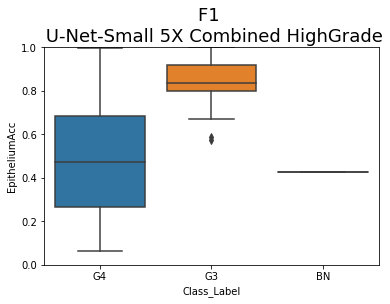

In [36]:
sns.boxplot(x="Class_Label", y="EpitheliumAcc", data=perf_df)
plt.ylim([0, 1.])

plt.title('F1 \n U-Net-Small 5X Combined HighGrade', fontsize=18)


# Draw masks into a figure

31
../tfhub/inference/inception_v3/1304732_prob.npy 1304732
(76, 116) [  0 255]
(76, 116) (76, 116, 3)


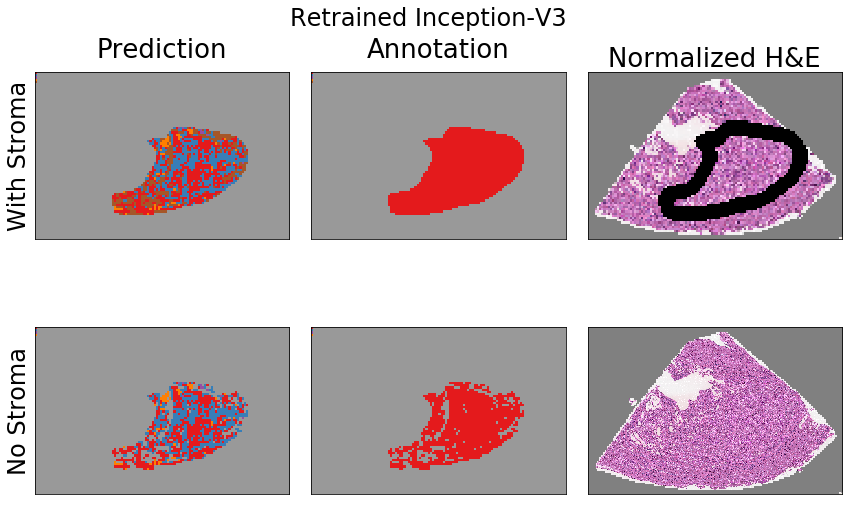

In [115]:
inf_list = glob.glob('../tfhub/inference/inception_v3/*npy')

# inf_list = glob.glob('../unet/10x/inference/*npy')

rgb_list = glob.glob('../unet/10x/inference/*rgb.jpg')

rgb_paths = pd.DataFrame(rgb_list, index=[os.path.basename(x).replace('_rgb.jpg', '') for x in rgb_list])
print(len(inf_list))

# inf_path = np.random.choice(inf_list,1)[0]
inf_path = '../tfhub/inference/inception_v3/1304732_prob.npy'
inf_base = os.path.basename(inf_path).replace('_prob.npy', '')
print(inf_path, inf_base)

x = np.load(inf_path)
mask = cv2.imread(mask_paths.loc[inf_base,0], -1)
rgb = cv2.imread(rgb_paths.loc[inf_base,0], -1)[:,:,::-1]
x_, y_ = x.shape[:2]
mask = cv2.resize(mask, dsize=(y_, x_), interpolation=cv2.INTER_NEAREST)
print(mask.shape, np.unique(mask))

fig, axs = plt.subplots(2,3,figsize=(12, 8))
    
amax = np.argmax(x, axis=-1)
## Take away unannotated area
amax[mask==255] = 6
mask[mask==255] = 6

mask[0:5, 0] = np.arange(5)
amax[0:5, 0] = np.arange(5)

axs[0][0].matshow(amax, cmap='Set1')
axs[0][0].set_yticks([])
axs[0][0].set_xticks([])
axs[0][0].set_title('Prediction', fontsize=26)
axs[0][0].set_ylabel('With Stroma', fontsize=24)

axs[0][1].matshow(mask, cmap='Set1')
axs[0][1].set_yticks([])
axs[0][1].set_xticks([])
axs[0][1].set_title('Annotation', fontsize=26)

rgb_marked = draw_contour(mask, rgb)
axs[0][2].imshow(rgb_marked)
axs[0][2].set_yticks([])
axs[0][2].set_xticks([])
axs[0][2].set_title('Normalized H&E', fontsize=26)

## Take away stroma
mask[amax==4] = 6
amax[amax==4] = 6

# rgb_marked = draw_contour_all(mask, rgb)

axs[1][0].matshow(amax, cmap='Set1')
axs[1][0].set_yticks([])
axs[1][0].set_xticks([])
axs[1][0].set_ylabel('No Stroma', fontsize=24)

axs[1][1].matshow(mask, cmap='Set1')
axs[1][1].set_yticks([])
axs[1][1].set_xticks([])

axs[1][2].imshow(rgb)
axs[1][2].set_yticks([])
axs[1][2].set_xticks([])

plt.tight_layout()
plt.suptitle('Retrained Inception-V3', fontsize=24)
plt.savefig('/home/nathan/Dropbox/_papers/gleason_grade/wsi_pred_label_inception_v3.pdf', bbox_inches='tight')